## BiConMP Tutorial

In this example, we learn how to create a simple jump motion on Solo12 (quadruped robot) using the BiConMP solver. The tutorial runs you through how to define a contact plan, weights etc.. that the solver needs to find a solution for you. We can then visualize the solution with meshcat

In [7]:
# This file plays the mpc motion only in viz
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pinocchio as pin
from matplotlib import pyplot as plt

from robot_properties_solo.config import Solo12Config
from mpc.abstract_acyclic_gen import SoloAcyclicGen
from motions.weight_abstract import ACyclicMotionParams

# from plan_cartwheel import plan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
robot = Solo12Config.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data

viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

pin_robot = Solo12Config.buildRobotWrapper()
pin_robot = Solo12Config.buildRobotWrapper()
urdf = Solo12Config.urdf_path


q0 = np.array(Solo12Config.initial_configuration)
v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [8]:
plan = ACyclicMotionParams("solo12", "jump_fwd")

st = 0.4
flight_time = 0.3
T = 1.2
dt = 5e-2
dt = T/30

plan.n_col = 25
plan.dt_arr = plan.n_col*[dt,]
plan.plan_freq = [[0.3, 0, st + flight_time],
                  [0.5, st + flight_time, T]]

plan.cnt_plan = [[[ 1.,      0.3946,   0.14695,  0., 0.,  st    ],
                  [ 1.,      0.3946,  -0.14695,  0., 0.,  st    ],
                  [ 1.,      0.0054,   0.14695,  0., 0.,  st    ],
                  [ 1.,      0.0054,  -0.14695,  0., 0.,  st    ]],

                 [[ 0.,      0.3946,   0.14695,  0.,st, st + flight_time   ],
                  [ 0.,      0.3946,  -0.14695,  0., st, st + flight_time   ],
                  [ 0.,      0.0054,   0.14695,  0., st, st + flight_time   ],
                  [ 0.,      0.0054,  -0.14695,  0., st, st + flight_time   ]],

                 [[ 1.,      0.3946,   0.14695,  0.,st + flight_time, T ],
                  [ 1.,      0.3946,  -0.14695,  0., st + flight_time, T ],
                  [ 1.,      0.0054,   0.14695,  0., st + flight_time, T ],
                  [ 1.,      0.0054,  -0.14695,  0., st + flight_time, T ]]]


#  dynamic optimization params
plan.W_X = np.array([1e-5, 1e-5, 1e+5, 1e-4, 1e-4, 1e-4, 3e+4, 3e+4, 3e+4])
plan.W_X_ter = 10*np.array([1e-5, 1e-5, 1e5, 1e+2, 1e+1, 1e+2, 1e+5, 1e+5, 1e+5])
plan.W_F = np.array(4*[5e+0, 5e+0, 7e+0])
plan.rho = 7e+4

plan.X_nom = [[0.2, 0, 0.22, 0, 0, 0, 0, 0.00, 0.0, 0.0, st],
              [0.2, 0, 0.22, 0, 0, 0, 0, 0.0, 0., st, st+flight_time],
              [0.2, 0, 0.22, 0, 0, 0, 0, 0.0, 0., st+flight_time, T]]

plan.X_ter = [0.2, 0, 0.2, 0, 0, 0, 0, 0.0, 0.0]

plan.bounds = [[-0.25, -0.25, 0.1, 0.25, 0.25, 0.25, 0, st],
               [-0.25, -0.25, 0.1, 0.25, 0.25, 0.3, st, T]]

# ik optimization params

plan.cent_wt = [5e+1, 1e3]
plan.cnt_wt = 5e4

plan.swing_wt = [[[1e2, 0.3946,   0.14695,  0.0, st + 0.25*flight_time, st + 0.5*flight_time],
                  [1e2, 0.3946,   -0.14695,  0.0, st + 0.25*flight_time, st + 0.5*flight_time],
                  [1e2,  0.0054,   0.14695,  0., st + 0.25*flight_time, st + 0.5*flight_time],
                  [1e2,  0.0054,   -0.14695,  0., st + 0.25*flight_time, st + 0.5*flight_time]]]

x_reg1 = np.concatenate([q0, pin.utils.zero(rmodel.nv)])

state_wt_1 = np.array([1e-2, 1e-2, 1e-2] + [5.0, 5.0, 1e-2] + 4*[1e1, 1e-1, 1e-1] +
                      [0.00, 0.00, 1e-5] + [5.0, 5.0, 5.0] + 4*[3.5, 3.5, 3.5]
                      )

state_wt_2 = np.array([1e-2, 1e-2, 1e2] + [1e2, 1e2, 1e2] + 4*[1e1, 1e+2, 1e+2] +
                      [0.00, 0.00, 0.00] + [5.0, 5.0, 5.0] + 4*[3.5, 3.5, 3.5]
                      )

plan.state_reg = [np.hstack((x_reg1, [0, st+flight_time])), np.hstack((x_reg1, [st+flight_time, T]))]
plan.state_wt = [np.hstack((state_wt_1, [0, st+flight_time])), np.hstack((state_wt_2, [st+flight_time, T]))]
plan.state_scale = [[1e-3, 0, st+flight_time], [1e-3, st+flight_time, T]]

ctrl_wt = [0, 0, 0] + [1e-4, 1e-4, 1e-4] + [1e-4]*(rmodel.nv-6)
plan.ctrl_wt = [np.hstack((ctrl_wt, [0, st+flight_time])),np.hstack((ctrl_wt, [st+flight_time, T]))]
plan.ctrl_reg = [np.hstack((np.zeros(rmodel.nv), [0, st+flight_time])), 
                 np.hstack((np.zeros(rmodel.nv), [st+flight_time, T]))]
plan.ctrl_scale = [[1e-4, 0, st+flight_time], [1e-2, st+flight_time, T]]

# controller details
plan.kp = [[0.0, 0, st+flight_time], [2.5, st+flight_time, T]]
plan.kd = [[0.01, 0, st+flight_time], [0.1, st+flight_time, T]]



In [3]:
viz.viewer.jupyter_cell()

In [9]:
sim_t = 0.0
sim_dt = .001
index = 0
pln_ctr = 0
plan_freq = 0.8 # sec
update_time = 0.0 # sec (time of lag)
q = q0
v = v0

lag = int(update_time/sim_dt)

mg = SoloAcyclicGen(pin_robot, urdf)
mg.update_motion_params(plan, q, sim_t)

for o in range(2):
    contact_configuration = np.array([1,1,1,1])
    xs, us, f = mg.optimize(q, v, sim_t)
    xs = xs[lag:]
    us = us[lag:]
    f = f[lag:]

    time.sleep(0.001)
    for ind in range(int(plan_freq/sim_dt)):
        viz.display(xs[ind][:robot.model.nq])

    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq]
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:]

    sim_t += plan_freq

Initialized Kino-Dyn planner
Maximum iterations reached 
Final norm: 0.00198367
Cost Time : 0.0026209354400634766
Solve Time :  0.045876264572143555
Maximum iterations reached 
Cost Time : 0.0018467903137207031
Solve Time :  0.04044914245605469
Final norm: 0.001404


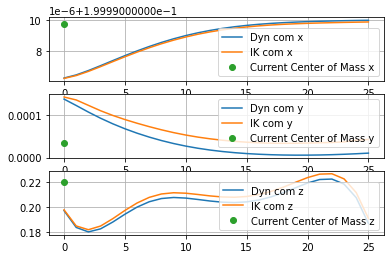

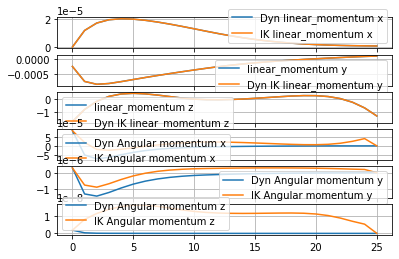

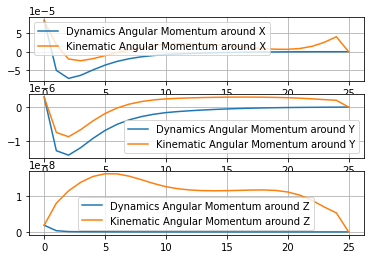

In [10]:
mg.plot(q, v, plot_force=False)